## Importing Packages

In [23]:
# TensorFlow
import tensorflow as tf
print(tf.__version__)

# nltk package
from nltk.stem import LancasterStemmer, SnowballStemmer, RegexpStemmer, WordNetLemmatizer 
#this was part of the NLP notebook
import nltk
nltk.download('punkt')

# import sentence tokenizer
from nltk import sent_tokenize
# import word tokenizer
from nltk import word_tokenize
# list of stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# string and regex for text manipulation
import string
import re

# managing data and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn key features
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

# machine learning models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

# emoji
!pip install emoji
import emoji

import pickle

2.3.1


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\grady\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Preparation

The data we use is from a Kaggle dataset in which the task is to do sentiment analysis on a set of tagged Twitter tweets regarding COVID-19 pandemic. Each tweet has been labeled with emotions, so this is a supervised classification task. 

To see the dataset, you can click the following link:
https://www.kaggle.com/gpreda/covid19-tweets

In [24]:
df = pd.read_csv(r'dataset\Corona_NLP_Kaggle_dataset.csv')

The kaggle dataset has divided the dataset into train and test dataset. However, for a thorough dataset exploration, we'll combine both dataset. Later, during the model creation process, we'll divide the combined data into our own train and test split, using the sklearn function ```train_test_split```.

In [25]:
df = df.reset_index(drop = True)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


There are 6 columns. We're going to remove the UserName and ScreenName column as they serve no purpose. 

In [26]:
df = df.drop(['UserName', 'ScreenName'], axis = 'columns')
df.isna().sum() #check for missing values

Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [27]:
df.Location.value_counts()

United States           603
London, England         568
London                  565
New York, NY            429
Washington, DC          411
                       ... 
California, Usa           1
Newport, Oregon, USA      1
India, unplugged          1
Skelmersdale, UK          1
SW PA                     1
Name: Location, Length: 13127, dtype: int64

There seems to be a lot of missing values for Location, and upon further inspection, the location given in these tweets are vague and often does not describe any location at all. 

Unless, there's a town named 'Watching TV in the Kitchen' or a city called 'Cyberspace!!!'

In [28]:
df = df.drop(['Location'], axis = 'columns')

In [29]:
df.head()

,TweetAt,OriginalTweet,Sentiment
0,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [30]:
df.Sentiment.value_counts()

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

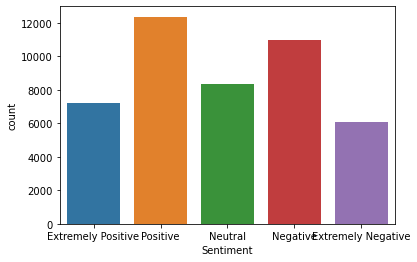

In [31]:
sns.countplot(x = 'Sentiment', data = df, 
              order = ['Extremely Positive', 'Positive', 'Neutral', 'Negative', 'Extremely Negative'])

As we can see, there are five classes of Sentiment. For this exercise, we'll combine the 'Extremely' classes to 'Positive' and 'Negative', so we'll end up with only 3 classes: Positive, Neutral, and Negative.

We'll encode them into numbers: Negative = 0, Neutral = 1, and Positive = 2.

The number of 'Positive' and 'Negative' class members will be around 14000 respectively each, while the number of 'Neutral' class members remains at around 8000. 

In [32]:
S_num = list()
S_text = list()
for label in df.Sentiment:
  if 'positive' in str(label).lower():
    S_num.append(2)
    S_text.append('Positive')
  elif 'negative' in str(label).lower():
    S_num.append(0)
    S_text.append('Negative')
  else:
    S_num.append(1)
    S_text.append('Neutral')
df = df.drop(['Sentiment'], axis = 'columns')
df['SentimentCode'] = S_num
df['Sentiment'] = S_text

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

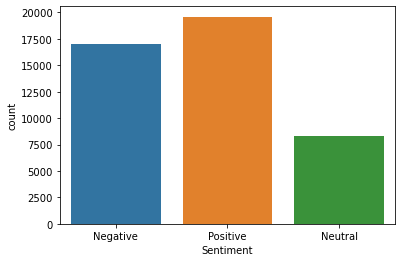

In [33]:
sns.countplot(x = 'Sentiment', data = df)

Next, just for fun, let's see if there is any relationship between sentiment of tweets and when the tweet was posted.

In [34]:
date_all = pd.to_datetime(df.TweetAt, format = '%d-%m-%Y')
df['day'] = date_all.dt.day_name()
df['date'] = date_all.dt.day
df['month'] = date_all.dt.month

In [35]:
df = df[['OriginalTweet', 'Sentiment', 'SentimentCode', 'day', 'date', 'month']]

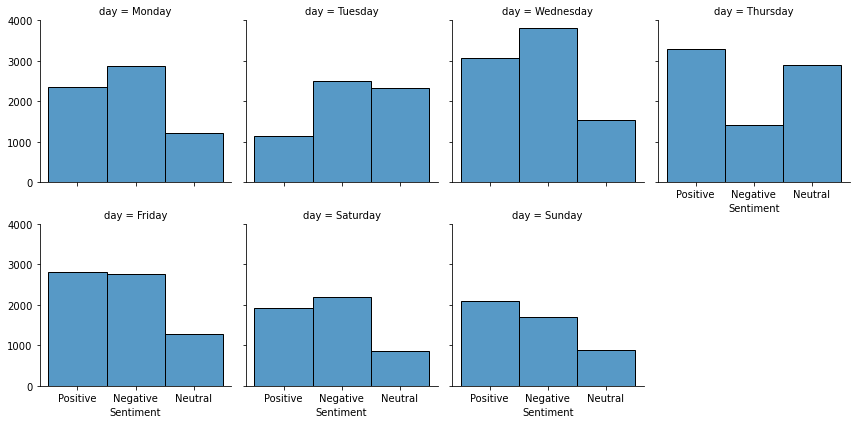

In [36]:
g = sns.FacetGrid(df, col="day", col_wrap = 4).set_xlabels()
g.map(sns.histplot, "Sentiment")

Based on the plots above, tweets generated on Monday usually are Negative ones, maybe because it's Monday. Other than Monday, it seems that the number of Positive tweets in each days outnumber the number of Negative and Neutral tweets. 

If that statement above make us conclude that people actually aren't that salty about COVID-19 (so they complain less in general, and tweet positive things), we might come to a wrong conclusion.

Remember, this is Twitter, and tweets with extremely negative remarks often come with derogatory language, disinformation, and/or other things that Twitter usually ban. 

So, there might be more negative tweets out there - they weren't recorded because they got deleted or removed by Twitter. 

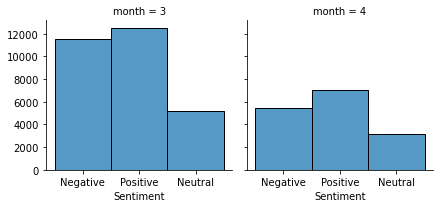

In [37]:
g = sns.FacetGrid(df, col="month", col_wrap = 3).set_xlabels()
g.map(sns.histplot, "Sentiment")

The above multigrid plots show that most tweets that we collect are from the 3rd month. The third month of 2020 is when COVID news really took off, and since most people were struck in panic, the tweets are mostly Negative. But 'Neutral' tweets come at a close second place, so we also cannot argue that 'a tweet in the 3rd month is mostly Negative'.

It seems that drawing visualizations of the number of tweets and time does not give us insights which can be used as features. 

## Data Preprocessing

Our tweets cannot be directly fed into machine learning models as they are not yet cleaned. Tweets often have mentions, hashtags, links, or symbols which may confuse our model since they are not 'pure words'. You can refresh the cell below to see a random tweet with their sentiment.

In [38]:
import random
from random import randint

rand_index = randint(0,40000)
print('The Tweet:')
print(df.OriginalTweet[rand_index])
print('Sentiment:')
print(df.Sentiment[rand_index])

The Tweet:
What the actual fuck!? Nobody should be letting their teens out the house. School and the mall are CLOSED! #Covid_19 #badparenting https://t.co/8WCGuTxdMo
Sentiment:
Negative


Let's see the top single word that appears in our tweets (before we clean them). Single words are called unigram in NLP terms.

In [39]:
def most_words(text, ngram, n):
  count = CountVectorizer(ngram_range=(ngram, ngram)).fit(text)
  vocab = count.transform(text)
  word_sum = vocab.sum(axis = 0)
  freq = [(word, word_sum[0, index]) for word, index in count.vocabulary_.items()]
  freq = sorted(freq, key = lambda x: x[1], reverse=True)
  return freq[:n]

most_frequent_single_words = most_words(df.OriginalTweet, ngram=1, n=10)
df_1word = pd.DataFrame(most_frequent_single_words, columns = ['Words', 'Amount'])
df_1word

,Words,Amount
0,the,49141
1,to,42219
2,and,26554
3,co,25956
4,https,25832
5,of,23616
6,in,21170
7,coronavirus,19677
8,for,15408
9,is,13581


This is why we need to clean our tweets. The most common words are without any meaning. Let's look at the most common 'two-words'. 'Two-words' are called bigrams in NLP terms.

In [40]:
most_frequent_two_words = most_words(df.OriginalTweet, ngram=2, n=10)
df_2word = pd.DataFrame(most_frequent_two_words, columns = ['Words', 'Amount'])
df_2word


,Words,Amount
0,https co,25796
1,covid 19,12413
2,grocery store,5450
3,to the,4237
4,in the,4008
5,of the,3310
6,the grocery,2497
7,the coronavirus,2351
8,the supermarket,2064
9,due to,1981


I rest my case. I come accross a medium article that serves as a great general guideline on how to preprocess our text before feeding it to a model. Here's the article: https://towardsdatascience.com/a-beginners-guide-to-preprocessing-text-data-using-nlp-tools-5cb52a8d3cd

We're going to preprocess our tweets with steps alike to the ones provided in the article.

In [41]:
#removing punctuation
punct =[]
punct += list(string.punctuation)
punct += '’'
punct.remove("'")
def remove_punctuations(text):
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

In [42]:
#remove emoji
def char_is_emoji(character):
    return character in emoji.UNICODE_EMOJI

def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [43]:
#string manipulation to clean the tweets
def clean_nlp(df): 
    #lowercase the text
    df['cleaned_tweet'] = df['OriginalTweet'].apply(lambda x: x.lower())
    #getting rid of whitespaces
    df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: x.replace('\n', ' '))
    #remove links
    df['cleaned_tweet'] = df['cleaned_tweet'].str.replace('http\S+|www.\S+', '', case=False)
    #removing '>'
    df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: x.replace('&gt;', ''))
    #removing '<'
    df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: x.replace('&lt;', ''))
    #checking emoji
    df['emoji'] = df['cleaned_tweet'].apply(lambda x: text_has_emoji(x))
    #remove emoji
    df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: deEmojify(x))
    #remove punctuation
    df['cleaned_tweet'] = df['cleaned_tweet'].apply(remove_punctuations)
    #remove ' s ' that was created after removing punctuations
    df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: str(x).replace(" s ", " "))
    return df

In [44]:
df = clean_nlp(df)

In [45]:
df.cleaned_tweet

0        trending  new yorkers encounter empty supermar...
1        when i couldn't find hand sanitizer at fred me...
2        find out how you can protect yourself and love...
3         panic buying hits  newyork city as anxious sh...
4         toiletpaper  dunnypaper  coronavirus  coronav...
                               ...                        
44950    airline pilots offering to stock supermarket s...
44951    response to complaint not provided citing covi...
44952    you know its getting tough when  kameronwilds ...
44953    is it wrong that the smell of hand sanitizer i...
44954     tartiicat well new used rift are going for  7...
Name: cleaned_tweet, Length: 44955, dtype: object

## Lemmatization using NLTK WordNet

Lemmatization is the step of changing words into their basic form. For example, the basic form of 'caring', 'cares', is 'care'. Lemmatization will find all other forms of 'care', and change it into 'care'.

Another alternative to lemmatization is stemming. Stemming does not change words - it trims a few letters on each words' end in an attempt to turn these words into their 'basic' form. But this is dangerous - 'caring' will get turned into 'car', which is an entirely different word.

English word lemmatization can be done by using a few packages in Python. We'll try this one using NLTK WordNet.

In [46]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  temp = []
  for word in text.split():
    word = lemmatizer.lemmatize(word)
    temp.append(word)

  return ' '.join(temp)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\grady\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


In [47]:
df['lemmatized'] = df['cleaned_tweet'].apply(lambda x: lemmatize(x))
#After lemmatization, some pronouns are changed to '-PRON' and we're going to remove it
df['lemmatized'] = df['lemmatized'].apply(lambda x: x.replace('-PRON-', ' '))

In [48]:
df.lemmatized

0        trending new yorkers encounter empty supermark...
1        when i couldn't find hand sanitizer at fred me...
2        find out how you can protect yourself and love...
3        panic buying hit newyork city a anxious shoppe...
4        toiletpaper dunnypaper coronavirus coronavirus...
                               ...                        
44950    airline pilot offering to stock supermarket sh...
44951    response to complaint not provided citing covi...
44952    you know it getting tough when kameronwilds is...
44953    is it wrong that the smell of hand sanitizer i...
44954    tartiicat well new used rift are going for 700...
Name: lemmatized, Length: 44955, dtype: object

## Tokenization

Tokenization is the process of turning the texts into tokens. The most common tokenization method is breaking sentences into each words. 

In [49]:
df['tokenized_tweet'] = df['lemmatized'].apply(word_tokenize)

## Removing Stop Words

Stop words are words that does not give any significant meaning as they can appear in both tweets with positive and negative sentiments, such as 'the', 'of', 'a', 'as', etc. 

A few Python packages contain stop words of English language. NLTK, Spacy, and even scikit-learn (sklearn) have built-in collection of words that they consider to be stop words.

In this exercise, we'll use the scikit-learn stopwords.

In [50]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
# create our own stop words set
custom_set = set()
# since 'coronavirus' and 'covid' appears in all 3 tweets, let's remove those words
custom_set.add('coronavirus')
custom_set.add('covid')
for stopword in ENGLISH_STOP_WORDS:
  custom_set.add(stopword)
df['tokenized_tweet'] = df['tokenized_tweet'].apply(lambda word_list: [x for x in word_list if x not in custom_set])

## Removing Numbers

In [51]:
df['tokenized_tweet'] = df['tokenized_tweet'].apply(lambda list_data: [x for x in list_data if x.isalpha()])

In [52]:
df.tokenized_tweet

0        [trending, new, yorkers, encounter, supermarke...
1        [hand, sanitizer, fred, meyer, turned, amazon,...
2                                         [protect, loved]
3        [panic, buying, hit, newyork, city, anxious, s...
4        [toiletpaper, dunnypaper, coronavirusaustralia...
                               ...                        
44950    [airline, pilot, offering, stock, supermarket,...
44951    [response, complaint, provided, citing, relate...
44952    [know, getting, tough, kameronwilds, rationing...
44953      [wrong, smell, hand, sanitizer, starting, turn]
44954    [tartiicat, new, used, rift, going, amazon, rn...
Name: tokenized_tweet, Length: 44955, dtype: object

In [53]:
finale = list()
for list_of_words in df.tokenized_tweet:
  finale.append(' '.join(list_of_words))

df['final_text'] = finale 

In [54]:
df.final_text

0        trending new yorkers encounter supermarket she...
1        hand sanitizer fred meyer turned amazon pack p...
2                                            protect loved
3        panic buying hit newyork city anxious shopper ...
4        toiletpaper dunnypaper coronavirusaustralia co...
                               ...                        
44950    airline pilot offering stock supermarket shelf...
44951    response complaint provided citing related del...
44952    know getting tough kameronwilds rationing toil...
44953             wrong smell hand sanitizer starting turn
44954    tartiicat new used rift going amazon rn normal...
Name: final_text, Length: 44955, dtype: object

## Top Bigrams of the Cleaned Tweets

### Bigrams for Positive Tweets

In [55]:
bigram_positive = most_words(df[df['Sentiment']=='Positive'].final_text, 
                                        ngram=2, n=10)
df_bigram_pos = pd.DataFrame(bigram_positive, columns = ['Words', 'Amount'])
df_bigram_pos

,Words,Amount
0,grocery store,2766
1,hand sanitizer,1399
2,online shopping,758
3,toilet paper,605
4,social distancing,330
5,store worker,324
6,stay home,316
7,stay safe,304
8,stock food,270
9,retail store,267


## Bigrams for Neutral Tweets

In [56]:
bigram_neutral = most_words(df[df['Sentiment']=='Neutral'].final_text, 
                                        ngram=2, n=10)
df_bigram_neu = pd.DataFrame(bigram_neutral, columns = ['Words', 'Amount'])
df_bigram_neu

,Words,Amount
0,grocery store,1091
1,online shopping,347
2,toilet paper,319
3,social distancing,127
4,oil price,124
5,retail store,117
6,consumer behavior,115
7,stock food,103
8,grocery shopping,83
9,shopping online,80


### Bigrams for Negative Tweets

In [57]:
bigram_negative = most_words(df[df['Sentiment']=='Negative'].final_text, 
                                        ngram=2, n=10)
df_bigram_neg = pd.DataFrame(bigram_negative, columns = ['Words', 'Amount'])
df_bigram_neg

,Words,Amount
0,grocery store,2020
1,panic buying,1124
2,oil price,744
3,toilet paper,653
4,online shopping,487
5,supermarket shelf,304
6,food bank,301
7,supply chain,260
8,food supply,255
9,stock food,222


We see that in the cleaned tweets, the top bigrams are not filled with stop words. Although some of the words appear in all three tables, we see that the Positive tweets have words such as 'social distancing', 'stay home', while Negative tweets have words related to 'panic buying'.

## TF-IDF Vectorization

TF-IDF (Term Frequency-Inverse Document Frequency) is an algorithm which transforms text into vectors of numbers which is then passed into machine learning algorithms for classification/prediction tasks.

The idea of NLP is how machine learning (or deep learning) models can recognize human language - and the current way to achieve that is by transforming sentences, words - into numerical vectors.

Now, let's conduct this algorithm on our preprocessed tweets.

In [58]:
X = df.final_text.copy()
y = df.SentimentCode.copy()

In [59]:
X

0        trending new yorkers encounter supermarket she...
1        hand sanitizer fred meyer turned amazon pack p...
2                                            protect loved
3        panic buying hit newyork city anxious shopper ...
4        toiletpaper dunnypaper coronavirusaustralia co...
                               ...                        
44950    airline pilot offering stock supermarket shelf...
44951    response complaint provided citing related del...
44952    know getting tough kameronwilds rationing toil...
44953             wrong smell hand sanitizer starting turn
44954    tartiicat new used rift going amazon rn normal...
Name: final_text, Length: 44955, dtype: object

In [60]:
Tfidf = TfidfVectorizer(min_df=5, ngram_range=(1, 2))
# min_df = 5 means 'ignore the words that appear in less than 5 'rows'
tfidf_v = Tfidf.fit_transform(X)
tfidf_v.shape

(44955, 23576)

## Training and Evaluating Classic Machine Learning Algorithms

We'll train four machine learning classifiers and compare their performance in classifying the Sentiment of tweets. But first, we'll have to split our dataset into train-test split.

### Splitting the Dataset

In [61]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_v, y, test_size = 0.15, random_state = 42)
def fit_and_eval(model):
  model.fit(X_train, y_train)
  predict = model.predict(X_test)
  from sklearn.metrics import classification_report
  print('Report:')
  print(classification_report(y_test, predict))

### Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class = 'multinomial', max_iter = 1000)
lr.fit(X_train, y_train)
fit_and_eval(lr)

Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2546
           1       0.74      0.60      0.66      1257
           2       0.80      0.85      0.82      2941

    accuracy                           0.79      6744
   macro avg       0.78      0.75      0.76      6744
weighted avg       0.79      0.79      0.78      6744



### Decision Tree Classifier

In [63]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
fit_and_eval(dt)

Report:
              precision    recall  f1-score   support

           0       0.65      0.64      0.64      2546
           1       0.53      0.57      0.55      1257
           2       0.70      0.68      0.69      2941

    accuracy                           0.64      6744
   macro avg       0.62      0.63      0.63      6744
weighted avg       0.65      0.64      0.64      6744



### XGBoost Classifier

In [64]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
fit_and_eval(xgb)

Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      2546
           1       0.64      0.73      0.69      1257
           2       0.79      0.79      0.79      2941

    accuracy                           0.76      6744
   macro avg       0.74      0.75      0.75      6744
weighted avg       0.76      0.76      0.76      6744



### Light GBM Classifier

In [65]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
fit_and_eval(lgb)

Report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      2546
           1       0.67      0.65      0.66      1257
           2       0.76      0.79      0.78      2941

    accuracy                           0.75      6744
   macro avg       0.73      0.73      0.73      6744
weighted avg       0.74      0.75      0.75      6744



Out of four algorithms, we obtain the highest accuracy in Logistic Regression. Based on the report, our model predicts a 'Positive Sentiment' tweet a bit better than Negative and Neutral ones. 

Now, let's try to tackle this classification problem using Deep Learning with TensorFlow and Keras.

## Saving ML Models

In [1]:
# saving linear regression model
lr.fit(tfidf_v, y)
pickle.dump(lr, open("lr.pickle", "wb"))

# saving decision tree model
dt.fit(tfidf_v, y)
pickle.dump(dt, open("dt.pickle", "wb"))

# saving xgboost model
xgb.fit(tfidf_v, y)
pickle.dump(xgb, open("xgb.pickle", "wb"))

# saving lgbm model
lgb.fit(tfidf_v, y)
pickle.dump(lgb, open("lgb.pickle", "wb"))


NameError: name 'lr' is not defined

## Deep Learning Sentiment Classification

We're going to use TensorFlow in this deep learning. The process is similar to what we did above - in fact, we're going to use ```df.final_text``` in this case. However, we're using keras' tokenizer to do the word embedding, and we're training the model using, well, a neural network model.

In [46]:
X = df.final_text.copy()
y = df.SentimentCode.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [47]:
y_test

33054    2
33564    2
32707    2
13252    0
37837    2
        ..
36024    1
3442     2
631      2
19110    1
40905    0
Name: SentimentCode, Length: 6744, dtype: int64

In [48]:
#maximum number of distinct words recognized
vocab_size = 40000 
#embedding dimension
embedding_dim = 32
#maximum length of vector
max_length = 130
#truncation type
trunc_type='post'
#out of vocabulary token (what to label words that does not exist in vocabulary)
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Tokenize our tweets
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


After tokenizing and padding our tweets, we'll create a model to train it. This model involves multiple layers of neural networks, and the highlight here is the Bidirectional LSTM layer, which is explained further in my medium post linked to this notebook.

In [49]:
# Model Definition with LSTM
tf.keras.backend.clear_session()
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# hyper parameters
embedding_dim = 16
units = 256

model = tf.keras.Sequential([
    # word embedding layer
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # normalization layer
    tf.keras.layers.BatchNormalization(),
    # Bidirectional LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units,return_sequences=True)),
    # Pooling layer
    tf.keras.layers.GlobalMaxPool1D(),
    # Adding dropout layer to avoid overfitting
    tf.keras.layers.Dropout(0.5),
    # Dense layer
    tf.keras.layers.Dense(32, activation="relu"),
    # Output layer. The unit size is 3 since we have 3 different classes
    tf.keras.layers.Dense(3, activation='sigmoid')
])

# Since our target is classification into '0', '1', or '2'....
# ...the loss function is Sparse Categorical Crossentropy
# Read more about keras loss functions in their documentation
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

num_epochs = 3
history = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 16)           640000    
_________________________________________________________________
batch_normalization (BatchNo (None, 130, 16)           64        
_________________________________________________________________
bidirectional (Bidirectional (None, 130, 512)          559104    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

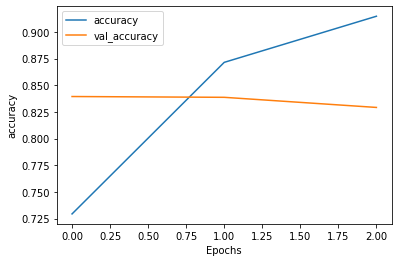

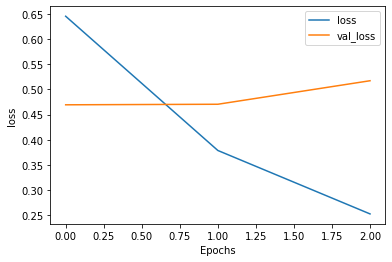

In [50]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

It seems we're overfitting. Let's reduce the training to 2 epochs only and tweak the model a bit.

In [51]:
# Model Definition with LSTM
tf.keras.backend.clear_session()
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# hyper parameters
embedding_dim = 16
units = 512

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units,return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='nadam',metrics=['accuracy']
             )

model.summary()

num_epochs = 2
history = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 16)           640000    
_________________________________________________________________
batch_normalization (BatchNo (None, 130, 16)           64        
_________________________________________________________________
bidirectional (Bidirectional (None, 130, 1024)         2166784   
_________________________________________________________________
global_max_pooling1d (Global (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

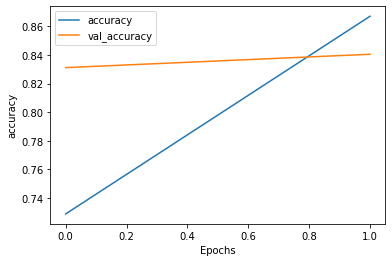

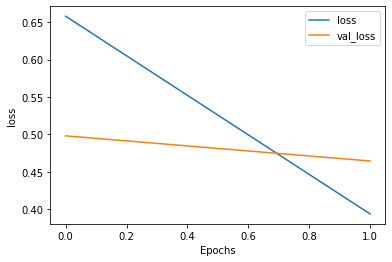

In [52]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

With just two epochs, we managed to get an accuracy of around 83%. Let's make a classification report and see how it compares against our machine learning models.

In [53]:
prediction = model.predict(testing_padded)

In [54]:
prediction

array([[1.5799212e-03, 4.3437598e-04, 9.9999237e-01],
       [2.0867933e-03, 6.5331563e-04, 9.9998248e-01],
       [8.9527160e-01, 3.0214639e-02, 4.4205523e-01],
       ...,
       [7.1321540e-02, 1.9254729e-02, 9.9485403e-01],
       [1.4512123e-01, 9.7232598e-01, 5.8041107e-02],
       [9.4713652e-01, 6.9610164e-02, 2.9997790e-01]], dtype=float32)

In [55]:
deep_learning_prediction = list()
for _ in prediction:
  deep_learning_prediction.append(np.argmax(_))

In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_test, deep_learning_prediction))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2527
           1       0.84      0.72      0.77      1294
           2       0.87      0.87      0.87      2923

    accuracy                           0.84      6744
   macro avg       0.84      0.82      0.83      6744
weighted avg       0.84      0.84      0.84      6744



That's a better classification report than our four machine learning algorithms. Before saving our model, we'll train our latest model once again using all data.


In [63]:
# Model Definition with LSTM
tf.keras.backend.clear_session()

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


from tensorflow.keras.losses import SparseCategoricalCrossentropy

# hyper parameters
embedding_dim = 16
units = 512

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units,return_sequences=True)),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='nadam',metrics=['accuracy']
             )

model.summary()

num_epochs = 2
history = model.fit(padded, y, epochs=num_epochs)
model.save_weights('weights.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 16)           640000    
_________________________________________________________________
batch_normalization (BatchNo (None, 130, 16)           64        
_________________________________________________________________
bidirectional (Bidirectional (None, 130, 1024)         2166784   
_________________________________________________________________
global_max_pooling1d (Global (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

## Try to Predict Your Own 'Tweets'!

What if we want to use our models here to predict our own tweet? 

In [64]:
# define preprocessing function
def preprocess_tweet(tweet):
  input = list()
  input.append(tweet)
  df_input = pd.DataFrame()
  df_input['OriginalTweet'] = input
  # lowercase the text
  df_input['cleaned_tweet'] = df_input['OriginalTweet'].apply(lambda x: x.lower())
  # getting rid of whitespaces
  df_input['cleaned_tweet'] = df_input['cleaned_tweet'].apply(lambda x: x.replace('\n', ' '))
  # remove links
  df_input['cleaned_tweet'] = df_input['cleaned_tweet'].str.replace('http\S+|www.\S+', '', case=False)
  # removing '>'
  df_input['cleaned_tweet'] = df_input['cleaned_tweet'].apply(lambda x: x.replace('&gt;', ''))
  # removing '<'
  df_input['cleaned_tweet'] = df_input['cleaned_tweet'].apply(lambda x: x.replace('&lt;', ''))
  # checking emoji
  df_input['emoji'] = df_input['cleaned_tweet'].apply(lambda x: text_has_emoji(x))
  # remove emoji
  df_input['cleaned_tweet'] = df_input['cleaned_tweet'].apply(lambda x: deEmojify(x))
  # remove punctuation
  df_input['cleaned_tweet'] = df_input['cleaned_tweet'].apply(remove_punctuations)
  # remove ' s ' that was created after removing punctuations
  df_input['cleaned_tweet'] = df_input['cleaned_tweet'].apply(lambda x: str(x).replace(" s ", " "))
  # apply lemmatization
  df_input['lemmatized'] = df_input['cleaned_tweet'].apply(lambda x: lemmatize(x))
  # After lemmatization, some pronouns are changed to '-PRON' and we're going to remove it
  df_input['lemmatized'] = df_input['lemmatized'].apply(lambda x: x.replace('-PRON-', ' '))
  # apply tokenization
  df_input['tokenized_tweet'] = df_input['lemmatized'].apply(word_tokenize)
  # remove stop words
  df_input['tokenized_tweet'] = df_input['tokenized_tweet'].apply(lambda word_list: [x for x in word_list if x not in custom_set])
  # remove numbers
  df_input['tokenized_tweet'] = df_input['tokenized_tweet'].apply(lambda list_data: [x for x in list_data if x.isalpha()])
  # finalizing the preprocessing
  finale = list()
  for list_of_words in df_input.tokenized_tweet:
    finale.append(' '.join(list_of_words))

  df_input['final_text'] = finale

  return df_input.final_text

# define tf-idf function (for machine learning algorithms)
def tfidf_text(tfidf_model, text):
  tfidf_new = TfidfVectorizer(ngram_range=(1,2), 
                              vocabulary = tfidf_model.vocabulary_)
  vector = tfidf_new.fit_transform(text)
  return vector

# define padding function (for deep learning algorithm)
def padding(tokenizer_model, text):
  sequence = tokenizer_model.texts_to_sequences(text)
  padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=130)
  return padded


In [65]:
def predict_proba(model, vector, print_all = False, deep_learning = False):
  if deep_learning == False:
    array = model.predict_proba(vector)
    prediction = model.predict(vector)[0]
  else:
    array = model.predict(vector)
    prediction = np.argmax(array)

  neg_proba = array[0][0]
  neu_proba = array[0][1]
  pos_proba = array[0][2]

  if print_all == True:
    print('Positive Sentiment Probability: ', round(pos_proba*100,3), '%')
    print('Neutral Sentiment Probability: ', round(neu_proba*100, 3), '%')
    print('Negative Sentiment Probability: ', round(neg_proba*100, 3), '%')

  if prediction == 0:
    print ('Predicted Sentiment: Negative')
  elif prediction == 1:
    print ('Predicted Sentiment: Neutral')
  else:
    print ('Predicted Sentiment: Positive')
  
  output = {'Sentiment':['Positive', 'Neutral', 'Negative'],
            'Probability':[pos_proba, neu_proba, neg_proba]}
  df_output = pd.DataFrame(output, columns = ['Sentiment', 'Probability'])

  ax = sns.barplot(x = 'Sentiment', y = 'Probability',data = df_output)
  s = [pos_proba, neu_proba, neg_proba]

  for i,p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.003, str(round(s[i]*100,2))+'%',
            ha="center") 

  
  return df_output


Now, let's try to predict our own tweets.

In [76]:
raw_tweet = "we're all angry at the egoistic people who tries to benefit from others during this time of need"
tweet = preprocess_tweet(raw_tweet)
vector = tfidf_text(Tfidf, tweet)
pad = padding(tokenizer, tweet)

Predicted Sentiment: Negative


,Sentiment,Probability
0,Positive,0.269929
1,Neutral,0.167624
2,Negative,0.889086


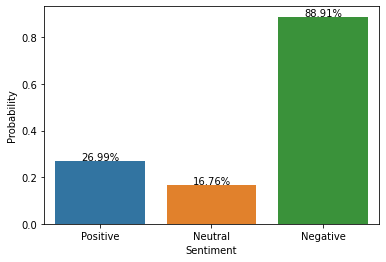

In [77]:
# predicting the sentiment using our deep learning model
predict_proba(model, pad, deep_learning=True)

Predicted Sentiment: Positive


,Sentiment,Probability
0,Positive,0.55
1,Neutral,0.02
2,Negative,0.43


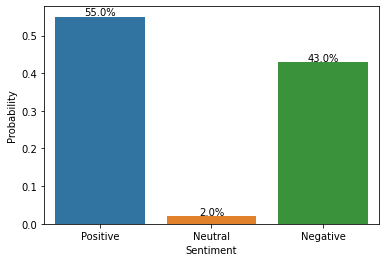

In [78]:
# prediction using random forest classifier
predict_proba(lr, vector)

The sample tweet is clearly a negative one. Our deep learning model classifies it correctly, but our logistic regression says that it's a positive tweet.

## Conclusion



*   We can train machine learning or deep learning models to recognize and classify sentiments within text.
*   Before being fed into models, our raw text has to be cleaned, lemmatized, tokenized, then having stop words removed, and finally vectorized. 
*   There are a few NLP packages which helps us to do the steps above. Some notorious ones are nltk and spacy.
* In this project, our deep learning model performed better than all machine learning models. This is because our deep learning model uses Bidirectional Long Short Term Memory layer. 



## Saving TF-IDF and Tokenizer

In [72]:
# saving tf-idf model
pickle.dump(Tfidf, open("Tfidf.pickle", "wb"))

# saving deep learning tokenizer
pickle.dump(tokenizer, open("tokenizer.pickle", "wb"))
